In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import data visualization
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# import image processing and computer vision
import cv2 as cv

# import data augmentation
import albumentations as albu

![image](https://github.com/Lexie88rus/Bengali_AI_Competition/raw/master/assets/samples.png)

# Bengali.AI EDA

## Introduction

__Bengali is the 5th most spoken language in the world__ with hundreds of million of speakers. It’s the official language of Bangladesh and the second most spoken language in India. Considering its reach, there’s significant business and educational interest in developing AI that can optically recognize images of the language handwritten. This challenge hopes to improve on approaches to Bengali recognition.

Optical character recognition is particularly challenging for Bengali. While Bengali has 49 letters (to be more specific 11 vowels and 38 consonants) in its [alphabet](https://en.wikipedia.org/wiki/Bengali_alphabet), there are also 18 potential [diacritics](https://en.wikipedia.org/wiki/Diacritic), or [accents](https://www.computerhope.com/jargon/a/accent.htm). This means that there are many more graphemes, or the smallest units in a written language. The added complexity results in ~13,000 different grapheme variations (compared to English’s 250 graphemic units).

## Dataset Statistics

The list of files:

In [2]:
! ls ../input/bengaliai-cv19/

class_map.csv		   test_image_data_3.parquet
sample_submission.csv	   train.csv
test.csv		   train_image_data_0.parquet
test_image_data_0.parquet  train_image_data_1.parquet
test_image_data_1.parquet  train_image_data_2.parquet
test_image_data_2.parquet  train_image_data_3.parquet


In [3]:
# setup the input data folder
DATA_PATH = '../input/bengaliai-cv19/'

Load the labels and explore target classes and distribution of images between them:

In [4]:
# load the dataframes with labels
train_labels = pd.read_csv(DATA_PATH + 'train.csv')
test_labels = pd.read_csv(DATA_PATH + 'test.csv')
class_map = pd.read_csv(DATA_PATH + 'class_map.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [5]:
print('There are {} train images.'.format(len(train_labels)))
print('There are {} test images.'.format(len(test_labels.groupby(by=['image_id']).count())))
print('There are {} classes for all 3 targets.'.format(len(class_map)))

There are 200840 train images.
There are 12 test images.
There are 186 classes for all 3 targets.


In [6]:
# count the number of classes for each target
n_classes = class_map.groupby(by=['component_type']).count()

In [7]:
# source: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

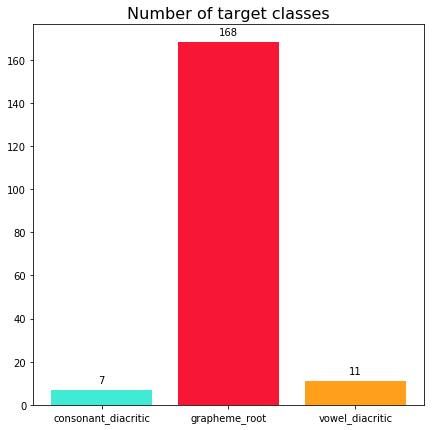

In [8]:
# plot bar chart with the number of classes to predict
fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.bar(range(0,len(n_classes.label.values)), n_classes.label.values, color=['#41EAD4', '#F71735', '#FF9F1C'])
plt.xticks(range(0,len(n_classes.label.values)), n_classes.index.values)
plt.title('Number of target classes', fontsize=16)
add_value_labels(ax)
plt.show()

Let's look at the number of images for each class:

In [9]:
# count the number of images for each grapheme_root
grapheme_root_img = train_labels.groupby(by=['grapheme_root']).count().reset_index()[['grapheme_root', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

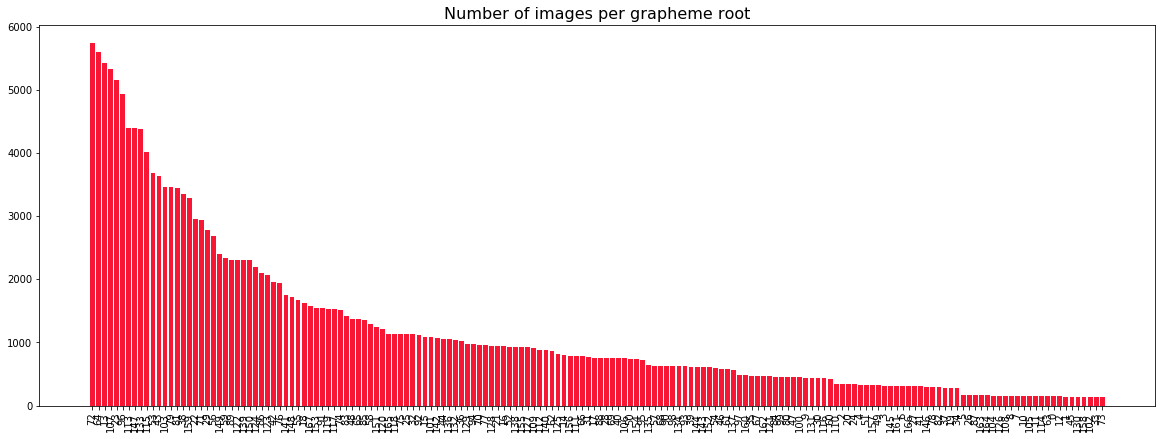

In [10]:
# plot bar chart with the number of images per each grapheme root
n_classes = len(grapheme_root_img)
fig, ax = plt.subplots(1,1,figsize=(20,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values, color='#F71735')
plt.xticks(range(0, n_classes), grapheme_root_img.grapheme_root.values, rotation=90)
plt.title('Number of images per grapheme root', fontsize=16)
plt.show()

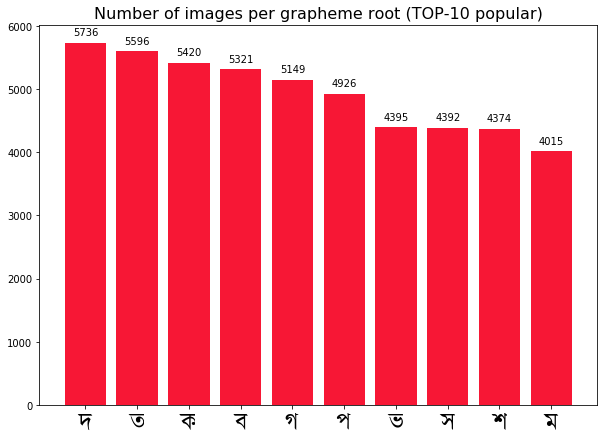

In [11]:
# plot bar chart with the top popular grapheme root class
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[:n_classes], color='#F71735')
labels = [class_map[class_map.label == val].component.values[0] for val in grapheme_root_img.grapheme_root.values[:n_classes]]
prop = FontProperties()
prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 popular)', fontsize=16)
add_value_labels(ax)
plt.show()

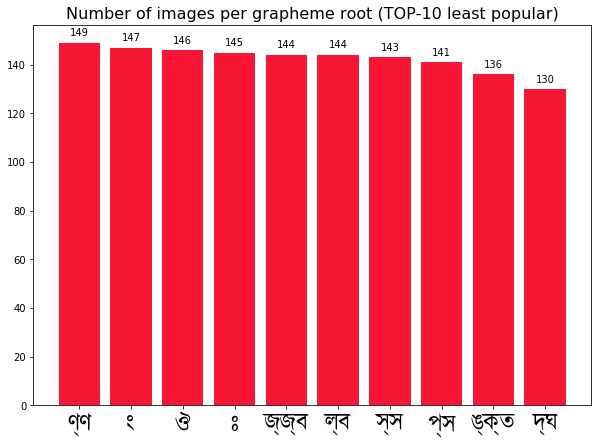

In [12]:
# plot bar chart with the top popular grapheme root class
n_classes = 10
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), grapheme_root_img.image_id.values[-n_classes:], color='#F71735')
labels = [class_map[class_map.label == val].component.values[0] for val in grapheme_root_img.grapheme_root.values[-n_classes:]]
prop = FontProperties()
prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per grapheme root (TOP-10 least popular)', fontsize=16)
add_value_labels(ax)
plt.show()

In [13]:
# count the number of images for each vowel_diacritic
vowel_diacritic_img = train_labels.groupby(by=['vowel_diacritic']).count().reset_index()[['vowel_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

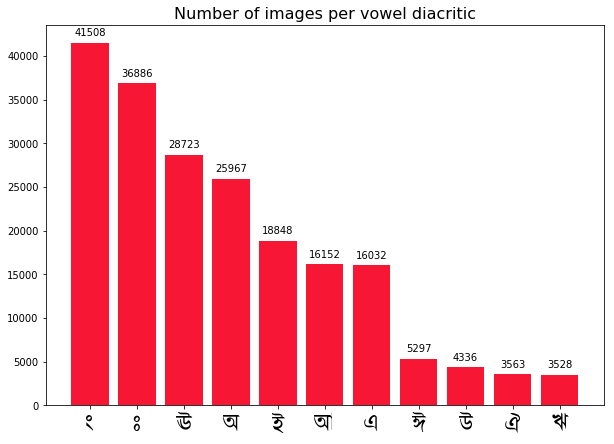

In [14]:
# plot bar chart with the number of images per each vowel_diacritic
n_classes = len(vowel_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), vowel_diacritic_img.image_id.values, color='#F71735')
labels = [class_map[class_map.label == val].component.values[0] for val in vowel_diacritic_img.vowel_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per vowel diacritic', fontsize=16)
add_value_labels(ax)
plt.show()

In [15]:
# count the number of images for each consonant_diacritic
consonant_diacritic_img = train_labels.groupby(by=['consonant_diacritic']).count().reset_index()[['consonant_diacritic', 'image_id']]\
.sort_values(by=['image_id'], ascending=False)

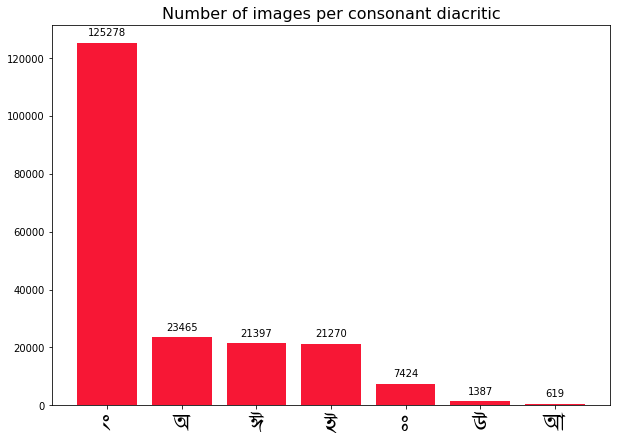

In [16]:
# plot bar chart with the number of images per each consonant_diacritic
n_classes = len(consonant_diacritic_img)
fig, ax = plt.subplots(1,1,figsize=(10,7))
plt.bar(range(0, n_classes), consonant_diacritic_img.image_id.values, color='#F71735')
labels = [class_map[class_map.label == val].component.values[0] for val in consonant_diacritic_img.consonant_diacritic.values]
plt.xticks(range(0, n_classes), labels, fontproperties=prop, fontsize=24)
plt.title('Number of images per consonant diacritic', fontsize=16)
add_value_labels(ax)
plt.show()

__Conclusions:__
* We have a __lot of target classes__. There are 168 classes for one of the target variables.
* The __distribution of images between the classes varies greately__, especially for `grapheme root` and `consonant diacritic`

## Visualize Sample Images

Load the first data file ([parquet format wiki page](https://en.wikipedia.org/wiki/Apache_Parquet)) and visualize sample image:

In [17]:
# load the 1st data file
train_df_1 = pd.read_parquet(DATA_PATH + 'train_image_data_0.parquet')
train_df_1.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [18]:
# setup image hight and width
HEIGHT = 137
WIDTH = 236

# function to visualize the images
def visualize_image(df, image_id):
    '''
    Helper function to visualize the image from dataframe by image_id
    '''
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    plt.imshow(img.astype(float), cmap='gray')
    plt.show()

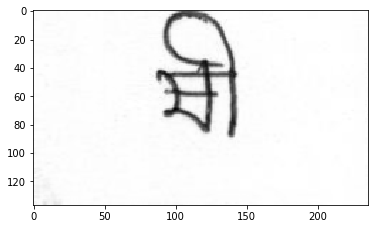

In [19]:
visualize_image(train_df_1, 'Train_7')

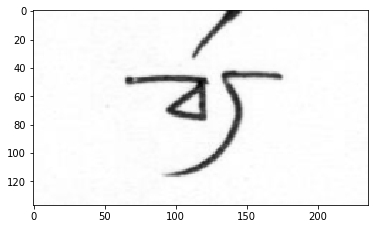

In [20]:
visualize_image(train_df_1, 'Train_11')

We can see that:
* there is no noise on the images,
* graphemes are not centered exactly.

Load all images:

In [21]:
def load_images():
    '''
    Helper function to load all train and test images
    '''
    train_list = []
    for i in range(0,4):
        train_list.append(pd.read_parquet(DATA_PATH + 'train_image_data_{}.parquet'.format(i)))
    train = pd.concat(train_list, ignore_index=True)
    
    test_list = []
    for i in range(0,4):
        test_list.append(pd.read_parquet(DATA_PATH + 'test_image_data_{}.parquet'.format(i)))
    test = pd.concat(test_list, ignore_index=True)
    
    return train, test

# function to visualize the images
def visualize_image_label(df, image_id, train_labels):
    '''
    Helper function to visualize the image from dataframe by image_id
    '''
    grapheme = train_labels[train_labels.image_id == image_id].grapheme.values[0]
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    plt.imshow(img.astype(float), cmap='gray')
    
    prop = FontProperties()
    prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
    
    plt.title(grapheme, fontproperties=prop, fontsize=20)
    plt.show()

In [22]:
# load the images
train, test = load_images()

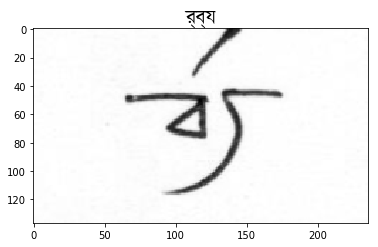

In [23]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_11', train_labels)

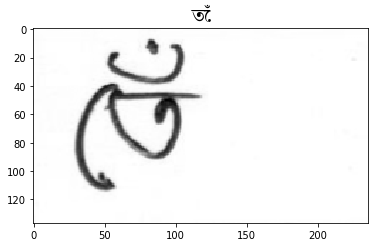

In [24]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_9', train_labels)

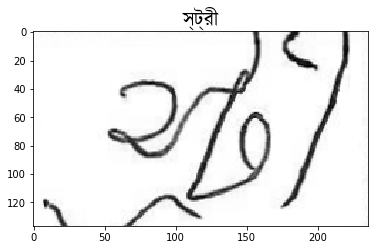

In [25]:
# visualize an image with label
visualize_image_label(train_df_1, 'Train_56', train_labels)

This grapheme didn't even fit in the image.[](http://)

Let's visualize sample images for the most popular graphemes:

In [26]:
def class_to_component(label):
    '''
    Helper function to get the component by label
    '''
    return class_map[class_map.label == label].component.values[0]

def visualize_sample_graphemes(classes_list, label_type = 'grapheme_root', img_per_class=5):
    '''
    Helper function to plot the sample images for a list of class labels of specified type
    '''
    img_per_class = img_per_class+1
    fig, axs = plt.subplots(len(classes_list), img_per_class, figsize=(20,10))
    for row in range(len(classes_list)):
        # get sample ids for the class from the list
        all_img_ids = train_labels[train_labels[label_type] == classes_list[row]].image_id.values
        # get random indices
        np.random.seed(123)
        idx = np.random.randint(len(all_img_ids), size=img_per_class)
        for col in range(img_per_class):
            if col > 0:
                # get the id of the image
                img_id = all_img_ids[idx[col-1]]
                # get the image by id
                img = train[train.image_id == img_id].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
                axs[row, col].imshow(img, cmap='gray')
                axs[row, col].axis('off')
            else:
                # plot the component as text
                component = class_to_component(classes_list[row])
                axs[row, col].text(0, 0, component, fontproperties=prop, fontsize=48)
                axs[row, col].axis('off')
    plt.suptitle('Sample Images for {}'.format(label_type), fontsize=16)
    plt.show()

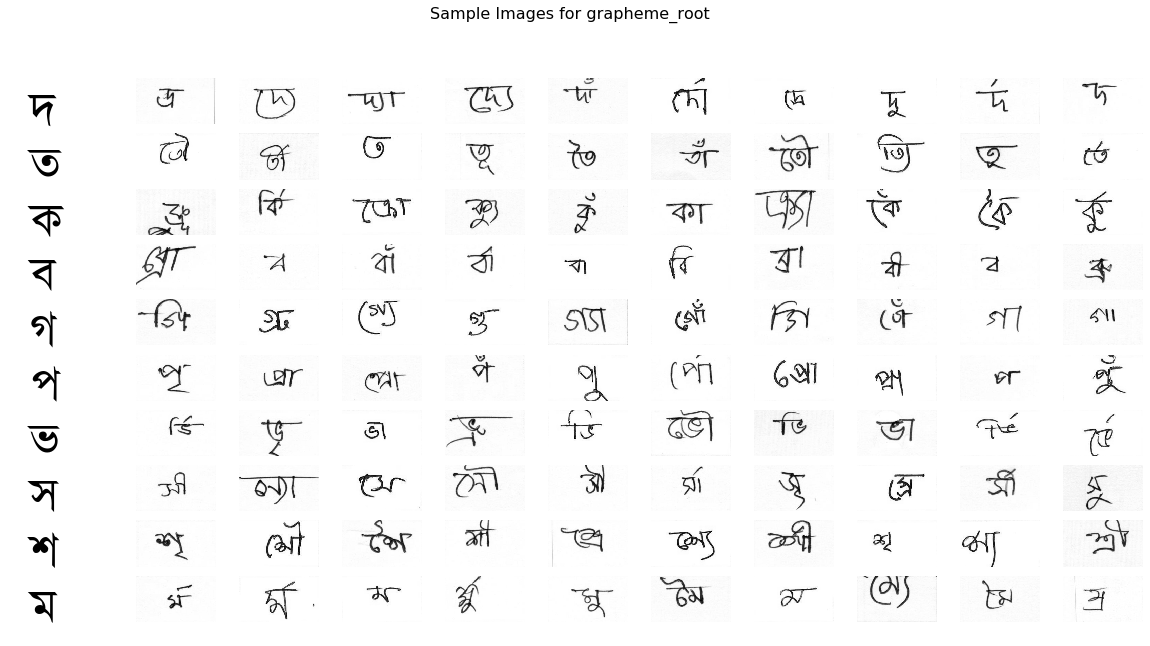

In [27]:
# get top grapheme_root classes
n_classes = 10
top_grapheme_root = grapheme_root_img.grapheme_root.values[:n_classes]
# visualize sample image
visualize_sample_graphemes(top_grapheme_root, label_type = 'grapheme_root', img_per_class=10)

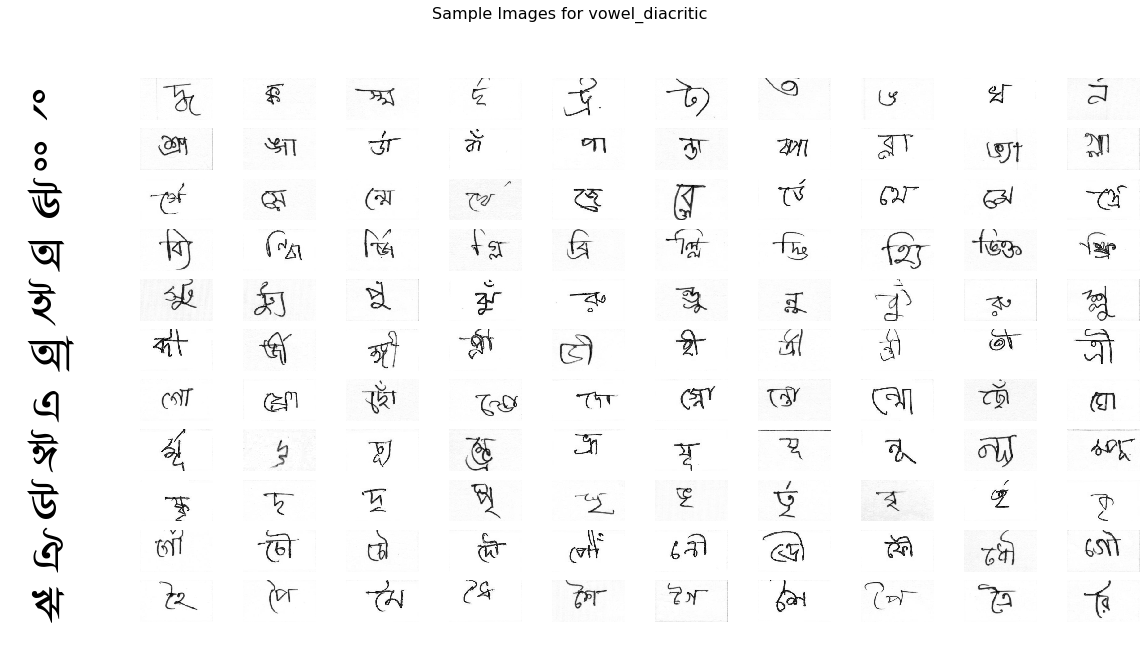

In [28]:
# visualize sample images for vowel_diacritic
visualize_sample_graphemes(vowel_diacritic_img.vowel_diacritic.values, label_type = 'vowel_diacritic', img_per_class=10)

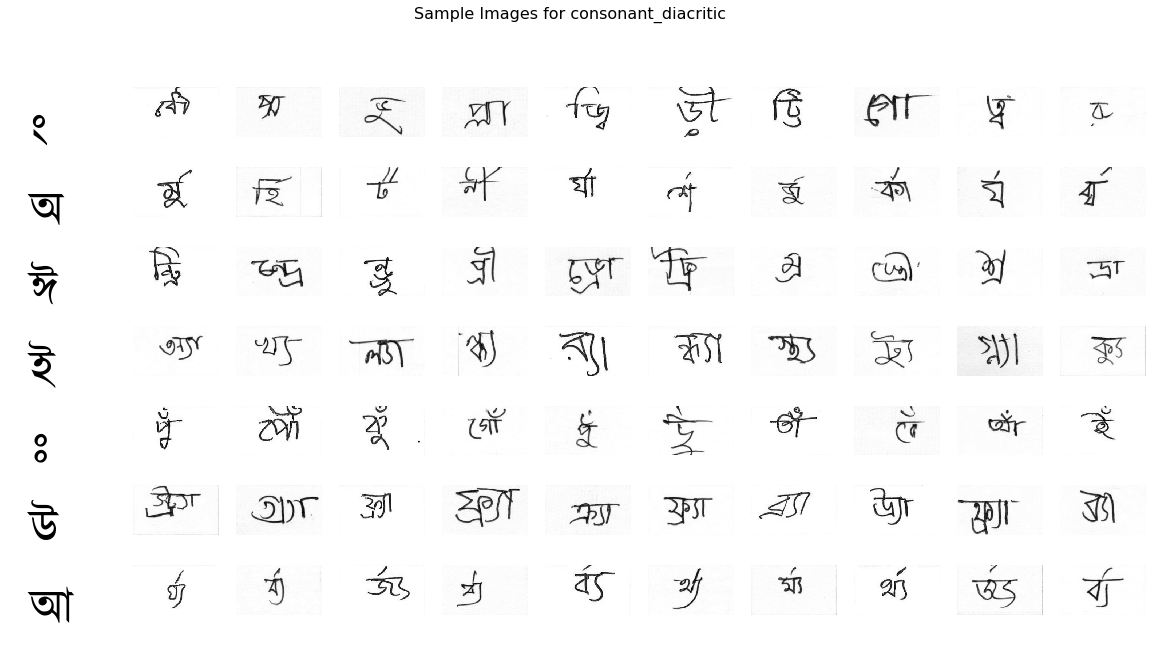

In [29]:
# visualize sample images for consonant_diacritic
visualize_sample_graphemes(consonant_diacritic_img.consonant_diacritic.values, label_type = 'consonant_diacritic', img_per_class=10)

__Conclusions:__
* The background is not clear on all of the images. That is why the initial preprocessing is required to threshold the images and eliminate the noise.

## Preprocess the Images

Let's try to preprocess the images by removing the background and noise with thresholding in OpenCV. I chose the adaptive thresholding with [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method).

In [30]:
import PIL
def threshold_image(img):
    '''
    Helper function for thresholding the images
    '''
    gray = PIL.Image.fromarray(np.uint8(img), 'L')
    ret,th = cv.threshold(np.array(gray),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def visualize_thresholded(df, image_id, train_labels):
    '''
    Function to visualize raw and thresholded images
    INPUT:
        df - train images dataframe
        image_id - id of the image
        train_labels - dataframe containing the training labels
    '''
    grapheme = train_labels[train_labels.image_id == image_id].grapheme.values[0]
    img = df[df.image_id == image_id].values[:, 1:].reshape(HEIGHT, WIDTH)
    img_th = threshold_image(img)
    
    fig, axs = plt.subplots(1,2,figsize=(7,4))
    
    axs[0].imshow(img.astype(float), cmap='gray')
    axs[0].set_title('original image')
    
    axs[1].imshow(img_th.astype(float), cmap='gray')
    axs[1].set_title('thresholded image')
    
    prop = FontProperties()
    prop.set_file('../input/bengaliaiutils/kalpurush.ttf')
    
    plt.suptitle(grapheme, fontproperties=prop, fontsize=20)
    plt.show()

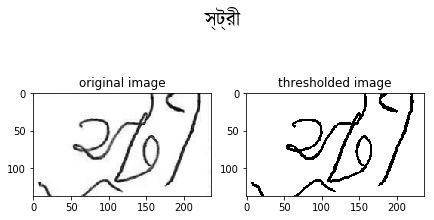

In [31]:
visualize_thresholded(train_df_1, 'Train_56', train_labels)

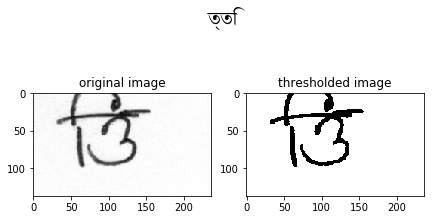

In [32]:
visualize_thresholded(train_df_1, 'Train_100', train_labels)

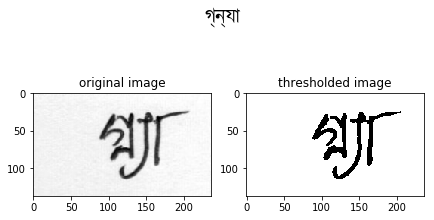

In [33]:
visualize_thresholded(train_df_1, 'Train_555', train_labels)

## Data Augmentation

Data augmentation is essential when building deep learning models. Good augmentation pipeline can improve the performance of the model dramatically! I suggest to try the following augmentations:
* random crop and resize;
* slight rotations;
* slight distortions.

I am using the [albumentations](https://github.com/albumentations-team/albumentations) library. This library is efficient and easy to use with most deep learning frameworks.

In [34]:
def apply_augmentation(img, augmentation):
    '''
    Helper function to apply the augmentation
    '''
    img_aug = augmentation(image=img)['image']
    return img_aug

def demonstrate_augmentation(aug, n_rows=5, n_cols=5, title=''):
    '''
    Helper function to plot the augmented images
    INPUT:
        aug - augmentation
        n_rows, n_cols - number of rows and cols for image grid
        title - title for a plot (for example, the name of visualization)
    '''
    # calculate the number of sample images
    n_img = n_rows * n_cols
    
    # get the random ids of sample images
    all_img_ids = train_labels.image_id.values
    np.random.seed(123)
    idx = np.random.randint(len(all_img_ids), size=n_img)
    image_ids = [all_img_ids[i] for i in idx]
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(7,5))
    for row in range(n_rows):
        for col in range(n_cols):
            count = row + col*n_cols
            # get the image by id
            img = train[train.image_id == image_ids[count]].values[:, 1:].reshape(HEIGHT, WIDTH).astype(float)
            
            # preprocess the image
            img_th = threshold_image(img)
            
            # apply the augmentation
            img_aug = apply_augmentation(img_th, aug)
            
            # plot the image
            axs[row, col].imshow(img_aug, cmap='gray')
            axs[row, col].axis('off')
            
    plt.suptitle('Augmentation demo {}'.format(title), fontsize=16)

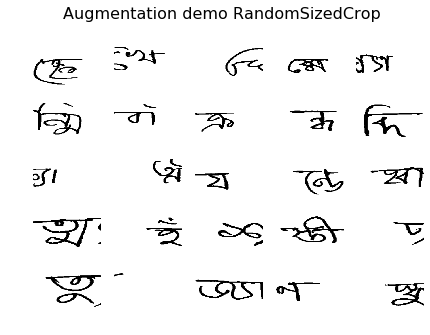

In [35]:
# Crop a random part of the input and rescale it to some size.
aug = albu.RandomSizedCrop(min_max_height=(int(HEIGHT // 1.1), HEIGHT), height = HEIGHT, width = WIDTH, p=1.0)

# demonstrate the augmentation on sample images
demonstrate_augmentation(aug, n_rows=5, n_cols=5, title='RandomSizedCrop')

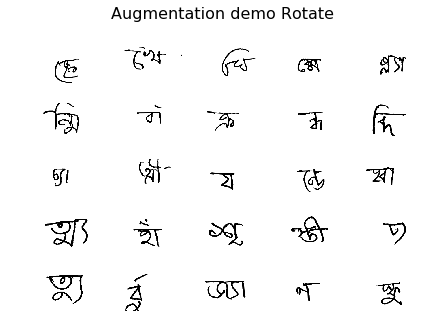

In [36]:
# Rotate the input by an angle selected randomly from the uniform distribution.
aug = albu.Rotate(limit=5, p=1.0)

# demonstrate the augmentation on sample images
demonstrate_augmentation(aug, n_rows=5, n_cols=5, title='Rotate')

We can even create a pipeline of these augmentations!

In [37]:
def pipeline_augmentations(p=.5):
    '''
    Function returns the pipeline of augmentations
    '''
    return albu.Compose([
        # compose the random cropping and random rotation
        albu.RandomSizedCrop(min_max_height=(int(HEIGHT // 1.1), HEIGHT), height = HEIGHT, width = WIDTH, p=0.5),
        albu.Rotate(limit=5, p=0.5)
    ], p=p)

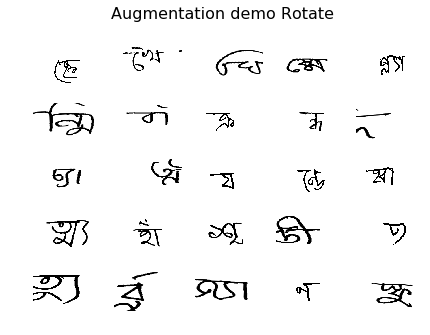

In [38]:
# demonstrate the augmentation pipeline on sample images
demonstrate_augmentation(pipeline_augmentations(p=.9), n_rows=5, n_cols=5, title='Rotate')

## Research Papers
You might find useful these research papers/repositories:

1. [Bengali Handwritten Character Classification using Transfer Learning on Deep Convolutional Neural Network](https://arxiv.org/html/1902.11133), [repo](https://github.com/swagato-c/bangla-hwcr-present): In this paper, we propose a solution which uses state-of-the-art techniques in Deep Learning to tackle the problem of Bengali Handwritten Character Recognition ( HCR ). Our method uses lesser iterations to train than most other comparable methods. We employ Transfer Learning on ResNet 50, a state-of-the-art deep Convolutional Neural Network Model, pretrained on ImageNet dataset. We also use other techniques like a modified version of One Cycle Policy, varying the input image sizes etc. to ensure that our training occurs fast. We use the BanglaLekha-Isolated Dataset for evaluation of our technique which consists of 84 classes (50 Basic, 10 Numerals and 24 Compound Characters). We are able to achieve 96.12% accuracy in just 47 epochs on BanglaLekha-Isolated dataset.
2. [A New Benchmark on the Recognition of Handwritten Bangla and Farsi Numeral Characters](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.544.9065&rep=rep1&type=pdf): In this work, we applied some advanced character recognition methods to handwritten Bangla and Farsi numeral recognition and evaluated the performance on three public databases: ISI Bangla numerals, CENPARMI Farsi numerals, and IFHCDB Farsi numerals.
3. [Hand Written Bangla Numerals Recognition for Automated Postal System ](https://www.researchgate.net/publication/325064193_Hand_Written_Bangla_Numerals_Recognition_for_Automated_Postal_System)(the full pdf is available for download): This paper delineate a robust hybrid system for recognition of handwritten Bangla numerals for the automated postal system, which performed feature extraction using k-means clustering, Baye’s theorem and Maximum a Posteriori, then the recognition is performed using Support Vector Machine . Recognition of handwritten numerals, such as postal codes, reveal all kinds of local and global deformations: distortions, different writing styles, thickness variations, wide variety of scales, limited amount of rotation, added noise, occlusion and missing parts.
4. [An Improved Feature Descriptor for Recognition of Handwritten Bangla Alphabet](https://arxiv.org/pdf/1501.05497.pdf): In the present work we have identified a new variation of feature set which significantly outperforms on handwritten Bangla alphabet from the previously used feature set. 132 number of features in all viz. modified shadow features, octant and centroid features, distance based features, quad tree based longest run features are used here. Using this feature set the recognition performance increases sharply from the 75.05% observed in our previous work, to 85.40% on 50 character classes with MLP based classifier on the same dataset. 
5. [Handwritten Bangla Character Recognition Using The State-of-Art Deep Convolutional Neural Networks](https://arxiv.org/pdf/1712.09872.pdf): application of the state-of-the-art Deep Convolutional Neural Networks (DCNN) including VGG Network, All Convolution Network (All-Conv Net), Network in Network (NiN), Residual Network, FractalNet, and DenseNet for HBCR. The deep learning approaches have the advantage of extracting and using feature information, improving the recognition of 2D shapes with a high degree of invariance to translation, scaling and other distortions.
6. [Multi-Column Deep Neural Networks for Offline Handwritten Chinese Character Classification](https://arxiv.org/pdf/1309.0261.pdf): Deep and wide max-pooling convolutional neural networks (MPCNN) on GPU embody the current state of the art in stationary pattern recognition. They outperformed other methods on image classification, object detection, and image segmentation. Through output averaging, several independently trained deep NN (DNN) can form a Multi-Column DNN (MCDNN) with error rates 20-40% below those of single DNN.
7. [Multi-column Deep Neural Networks for Image Classification](https://arxiv.org/pdf/1309.0261.pdf): Small (often minimal) receptive fields of convolutional winner-take-all neurons yield large network depth, resulting in roughly as many sparsely connected neural layers as found in mammals between retina and visual cortex. Only winner neurons are trained. Several deep neural columns become experts on inputs preprocessed in different ways; their predictions are averaged. Graphics cards allow for fast training. On the very competitive MNIST handwriting benchmark, our method is the first to achieve near-human performance. 

## References and Useful Links
1. [Bengali fonts](https://www.omicronlab.com/bangla-fonts.html) to use for matplotlib diagrams
2. [Thresholding tutorial](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) in OpenCV
3. [Common Bengali Handwritten Graphemes in Context](https://bengali.ai/wp-content/uploads/CV19-COCO-Grapheme.pdf) Introductory Booklet
4. [Consonant Conjuncts vs Consonant Diacritics](https://www.kaggle.com/c/bengaliai-cv19/discussion/123002) discussion

__Please, feel free to leave comments and/or questions! Your feedback is very welcome!__ 